In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import streamlit as st
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

False

In [3]:
print(os.getenv("TelCom"))
print(os.getenv("postgres"))
print(os.getenv("125191"))
print(os.getenv("localhost"))
print(os.getenv("5432"))


None
None
None
None
None


In [4]:
import pandas as pd

# Load dataset
df = pd.read_excel('../data/Week2_challenge_data_source.xlsx')

# Top 10 handsets
top_handsets = df['Handset Type'].value_counts().head(10)

# Top 3 manufacturers
df['Handset Manufacturer'] = df['Handset Type'].str.split().str[0]  # Assuming manufacturer is prefix
top_manufacturers = df['Handset Manufacturer'].value_counts().head(3)

# Top 5 handsets for each top manufacturer
for manufacturer in top_manufacturers.index:
    print(f"Top handsets for {manufacturer}:")
    print(df[df['Handset Manufacturer'] == manufacturer]['Handset Type'].value_counts().head(5))


Top handsets for Apple:
Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64
Top handsets for Samsung:
Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galaxy J5 (Sm-J530)     3696
Samsung Galaxy J3 (Sm-J330)     3484
Samsung Galaxy S7 (Sm-G930X)    3199
Name: count, dtype: int64
Top handsets for Huawei:
Handset Type
Huawei B528S-23A                  19752
Huawei E5180                       2079
Huawei P20 Lite Huawei Nova 3E     2021
Huawei P20                         1480
Huawei Y6 2018                      997
Name: count, dtype: int64


In [6]:
# Describe dataset and check data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  object        
 1   Start                                     150000 non-null  datetime64[ns]
 2   Start ms                                  150000 non-null  float64       
 3   End                                       150000 non-null  datetime64[ns]
 4   End ms                                    150000 non-null  float64       
 5   Dur. (ms)                                 150000 non-null  float64       
 6   IMSI                                      149431 non-null  float64       
 7   MSISDN/Number                             148935 non-null  float64       
 8   IMEI                                      149429 non-null  float64       
 9   Last Location N

In [7]:
print(df.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [13]:
# Convert the relevant columns to numeric types (if not already)
df['Total DL (Bytes)'] = pd.to_numeric(df['Total DL (Bytes)'], errors='coerce')
df['Total UL (Bytes)'] = pd.to_numeric(df['Total UL (Bytes)'], errors='coerce')

# Now, you can safely aggregate the data
df['Total Data (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Aggregate data by user (IMSI)
user_data = df.groupby('IMSI').agg(
    num_sessions=('Bearer Id', 'nunique'),
    total_duration=('Dur. (ms)', 'sum'),
    total_data=('Total Data (Bytes)', 'sum')
)


# Aggregate data for each application
applications = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)',
                'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

for app in applications:
    user_data[app] = df[app].sum()

# Show the result
print(user_data.head())


              num_sessions  total_duration    total_data  \
IMSI                                                       
2.040471e+14             1        869844.0  1.391536e+08   
2.040808e+14             1        877385.0  2.321240e+08   
2.082001e+14             1         86019.0  8.517164e+07   
2.082001e+14             1         86254.0  4.265016e+08   
2.082001e+14             2        573923.0  1.033092e+09   

              Social Media DL (Bytes)  Youtube DL (Bytes)  Netflix DL (Bytes)  \
IMSI                                                                            
2.040471e+14             2.693001e+11        1.745123e+12        1.744039e+12   
2.040808e+14             2.693001e+11        1.745123e+12        1.744039e+12   
2.082001e+14             2.693001e+11        1.745123e+12        1.744039e+12   
2.082001e+14             2.693001e+11        1.745123e+12        1.744039e+12   
2.082001e+14             2.693001e+11        1.745123e+12        1.744039e+12   

           

In [14]:
# Describe dataset and check data types
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 56 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  object        
 1   Start                                     150000 non-null  datetime64[ns]
 2   Start ms                                  150000 non-null  float64       
 3   End                                       150000 non-null  datetime64[ns]
 4   End ms                                    150000 non-null  float64       
 5   Dur. (ms)                                 150000 non-null  float64       
 6   IMSI                                      149431 non-null  float64       
 7   MSISDN/Number                             148935 non-null  float64       
 8   IMEI                                      149429 non-null  float64       
 9   Last Location N

In [15]:
user_data.fillna(user_data.mean(), inplace=True)

# Basic Metrics Analysis


In [20]:
# Summary statistics for key metrics
basic_metrics = user_data[['total_data', 'total_duration']].describe()
print(basic_metrics)


         total_data  total_duration
count  1.072650e+05    1.072650e+05
mean   6.906556e+08    1.459355e+05
std    4.908637e+08    1.863518e+05
min    3.324901e+07    7.142000e+03
25%    3.584885e+08    7.041100e+04
50%    6.176283e+08    1.024500e+05
75%    8.571685e+08    1.727990e+05
max    8.846226e+09    1.855375e+07


# Non-Graphical Univariate Analysis

In [21]:
# Dispersion metrics
dispersion_metrics = {
    'Variance': user_data.var(numeric_only=True),
    'Standard Deviation': user_data.std(numeric_only=True),
    'Range': user_data.max(numeric_only=True) - user_data.min(numeric_only=True),
    'Coefficient of Variation': user_data.std(numeric_only=True) / user_data.mean(numeric_only=True)
}
dispersion_metrics_df = pd.DataFrame(dispersion_metrics)
print(dispersion_metrics_df)


                             Variance  Standard Deviation         Range  \
num_sessions             6.031001e-01        7.765952e-01  1.700000e+01   
total_duration           3.472699e+10        1.863518e+05  1.854661e+07   
total_data               2.409472e+17        4.908637e+08  8.812977e+09   
Social Media DL (Bytes)  2.328328e-08        1.525886e-04  0.000000e+00   
Youtube DL (Bytes)       0.000000e+00        0.000000e+00  0.000000e+00   
Netflix DL (Bytes)       0.000000e+00        0.000000e+00  0.000000e+00   
Google DL (Bytes)        1.490130e-08        1.220709e-04  0.000000e+00   
Email DL (Bytes)         1.490130e-08        1.220709e-04  0.000000e+00   
Gaming DL (Bytes)        2.441429e-04        1.562507e-02  0.000000e+00   
Other DL (Bytes)         2.197286e-03        4.687522e-02  0.000000e+00   

                         Coefficient of Variation  
num_sessions                         5.630457e-01  
total_duration                       1.276946e+00  
total_data        

# Graphical Univariate Analysis

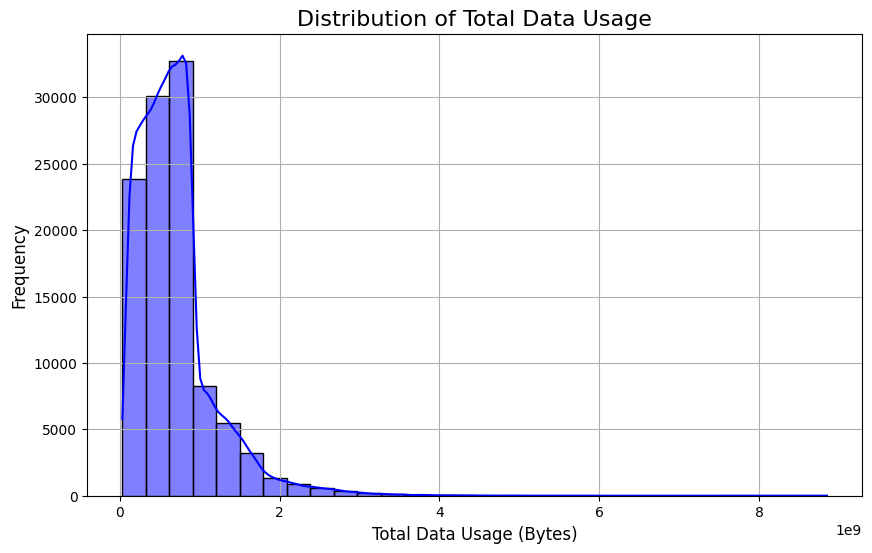

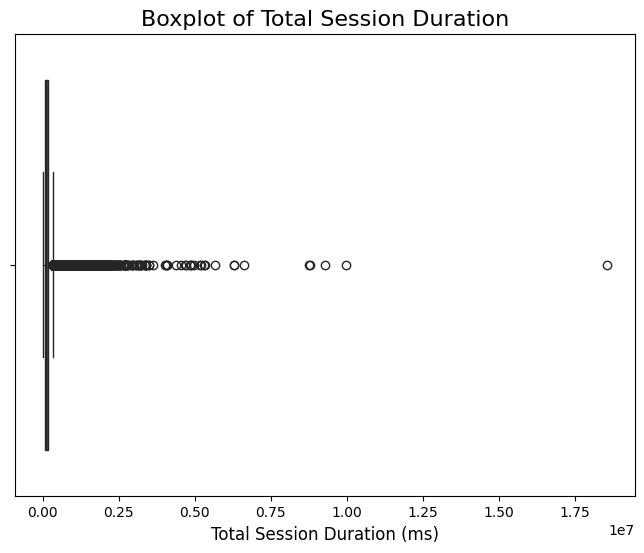

In [22]:
# Distribution of total data usage
plt.figure(figsize=(10, 6))
sns.histplot(user_data['total_data'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Data Usage', fontsize=16)
plt.xlabel('Total Data Usage (Bytes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid()
plt.show()

# Boxplot for session duration
plt.figure(figsize=(8, 6))
sns.boxplot(x=user_data['total_duration'], color='green')
plt.title('Boxplot of Total Session Duration', fontsize=16)
plt.xlabel('Total Session Duration (ms)', fontsize=12)
plt.show()


# Bivariate Analysis

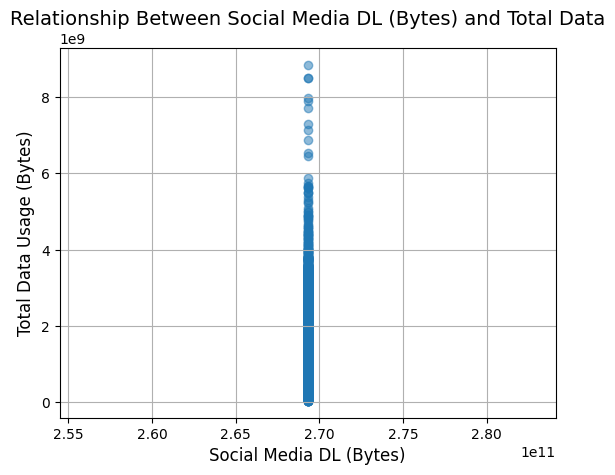

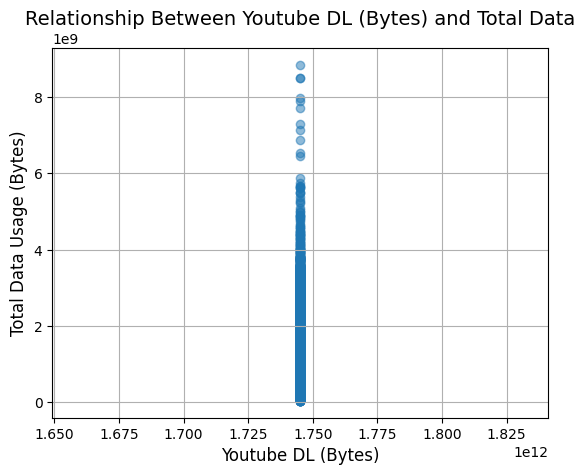

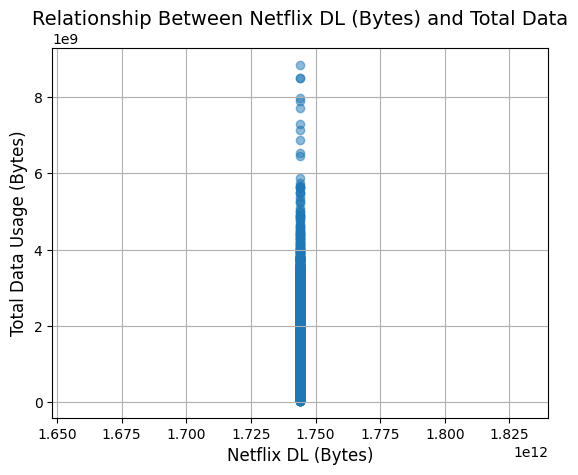

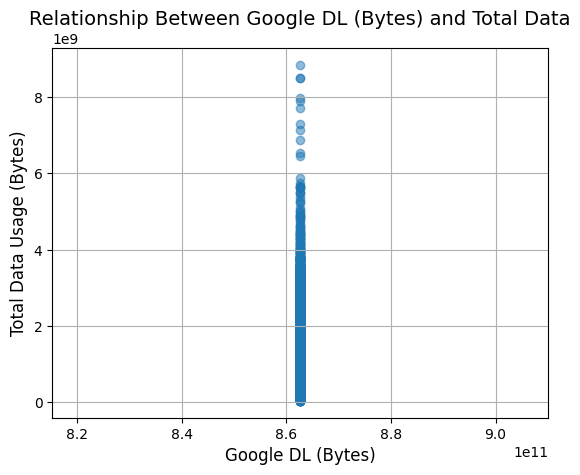

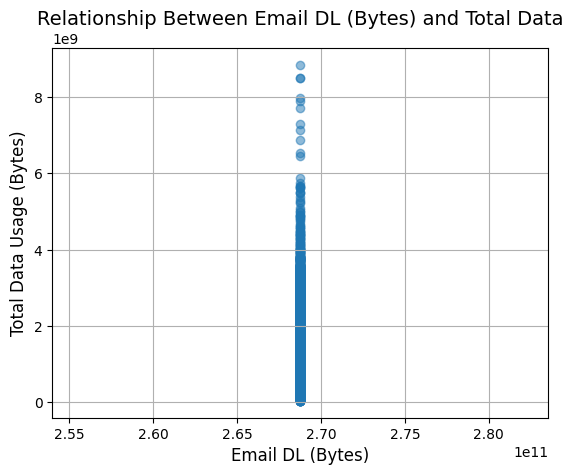

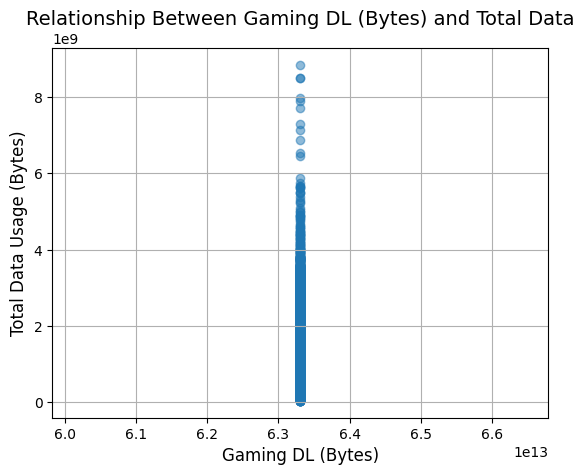

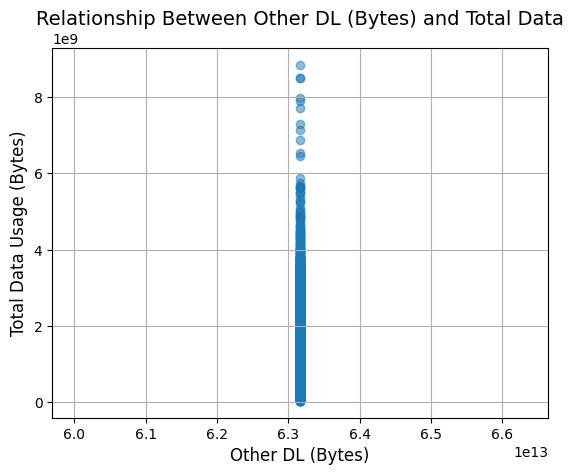

In [37]:

# Aggregate data for each application
applications = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)',
                'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
for app in applications:
    sns.regplot(x=user_data[app], y=user_data['total_data'], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f'Relationship Between {app} and Total Data', fontsize=14)
    plt.xlabel(f'{app}', fontsize=12)
    plt.ylabel('Total Data Usage (Bytes)', fontsize=12)
    plt.grid()
    plt.show()


Explained variance ratio: [0.75839123 0.24160877]


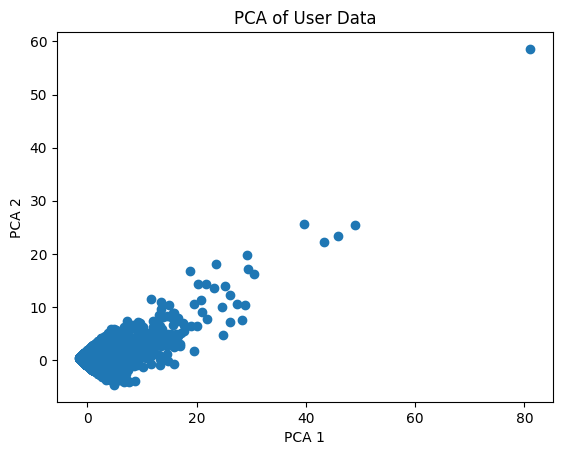

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA (use relevant columns from user_data)
# Assuming you want to use columns like 'total_duration', 'total_dl', 'total_ul', 'total_data', etc.
# Ensure you select numerical columns that are relevant to PCA

columns_to_use = ['total_duration','total_data']
app_data = user_data[columns_to_use]

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(app_data)

# Initialize PCA
pca = PCA(n_components=2)  # Reduce to 2 components, or any other number you prefer

# Fit PCA on the scaled data
pca_result = pca.fit_transform(scaled_data)

# You can now add the PCA components back to the original DataFrame or explore them
user_data['PCA1'] = pca_result[:, 0]
user_data['PCA2'] = pca_result[:, 1]

# Explained variance ratio
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

# Visualize the result (optional, for example, with a scatter plot)
import matplotlib.pyplot as plt
plt.scatter(user_data['PCA1'], user_data['PCA2'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of User Data')
plt.show()


# Correlation matrix

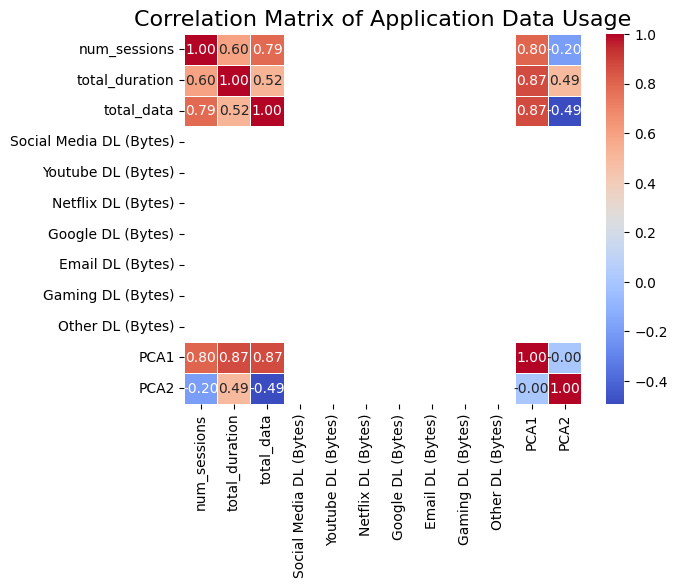

In [35]:
# Compute correlation matrix
correlation_matrix = user_data.corr()

# correlation_matrix = df['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other'].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Application Data Usage', fontsize=16)
plt.show()


#  Aggregate Engagement Metrics Per Customer (MSISDN)

In [ ]:
# Aggregate metrics per customer (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg(
    session_frequency=('Bearer Id', 'count'),  # Count sessions per user
    total_duration=('total_session_duration', 'sum'),  # Sum total duration per user
    total_traffic=('total_data', 'sum')  # Sum total data usage per user
).reset_index()

# Inspecting the top 10 customers for each engagement metric
top_session_frequency = engagement_metrics.nlargest(10, 'session_frequency')
top_total_duration = engagement_metrics.nlargest(10, 'total_duration')
top_total_traffic = engagement_metrics.nlargest(10, 'total_traffic')

# Display top customers for each metric
print("Top 10 Customers by Session Frequency")
print(top_session_frequency)

print("Top 10 Customers by Total Duration")
print(top_total_duration)

print("Top 10 Customers by Total Traffic")
print(top_total_traffic)


KeyError: 'MSISDN/Number'

# Normalize Engagement Metrics and Apply K-Means Clustering

In [149]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Normalize the engagement metrics
scaler = MinMaxScaler()
normalized_metrics = engagement_metrics[['session_frequency', 'total_duration', 'total_traffic']]
normalized_metrics_scaled = scaler.fit_transform(normalized_metrics)

# Apply K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['cluster'] = kmeans.fit_predict(normalized_metrics_scaled)

# Inspect the top 10 customers in each cluster
clustered_data = engagement_metrics.groupby('cluster').agg(
    min_frequency=('session_frequency', 'min'),
    max_frequency=('session_frequency', 'max'),
    avg_frequency=('session_frequency', 'mean'),
    total_frequency=('session_frequency', 'sum'),
    min_duration=('total_duration', 'min'),
    max_duration=('total_duration', 'max'),
    avg_duration=('total_duration', 'mean'),
    total_duration=('total_duration', 'sum'),
    min_traffic=('total_traffic', 'min'),
    max_traffic=('total_traffic', 'max'),
    avg_traffic=('total_traffic', 'mean'),
    total_traffic=('total_traffic', 'sum')
).reset_index()

print(clustered_data)


   cluster  min_frequency  max_frequency  avg_frequency  total_frequency  \
0        0              2              4       2.176052            47068   
1        1              3             18       4.248279            17282   
2        2              1              2       1.042226            84585   

   min_duration  max_duration   avg_duration  total_duration   min_traffic  \
0       18235.0     3174824.0  213600.528202    4.620179e+09  2.842182e+08   
1       46896.0    18553754.0  569329.970747    2.316034e+09  1.085994e+09   
2        7142.0     1573420.0  106984.202543    8.682624e+09  3.324901e+07   

    max_traffic   avg_traffic  total_traffic  
0  1.873330e+09  1.125421e+09   2.434285e+13  
1  8.846226e+09  2.280321e+09   9.276344e+12  
2  9.507607e+08  4.955057e+08   4.021425e+13  


# Visualizing the Clusters

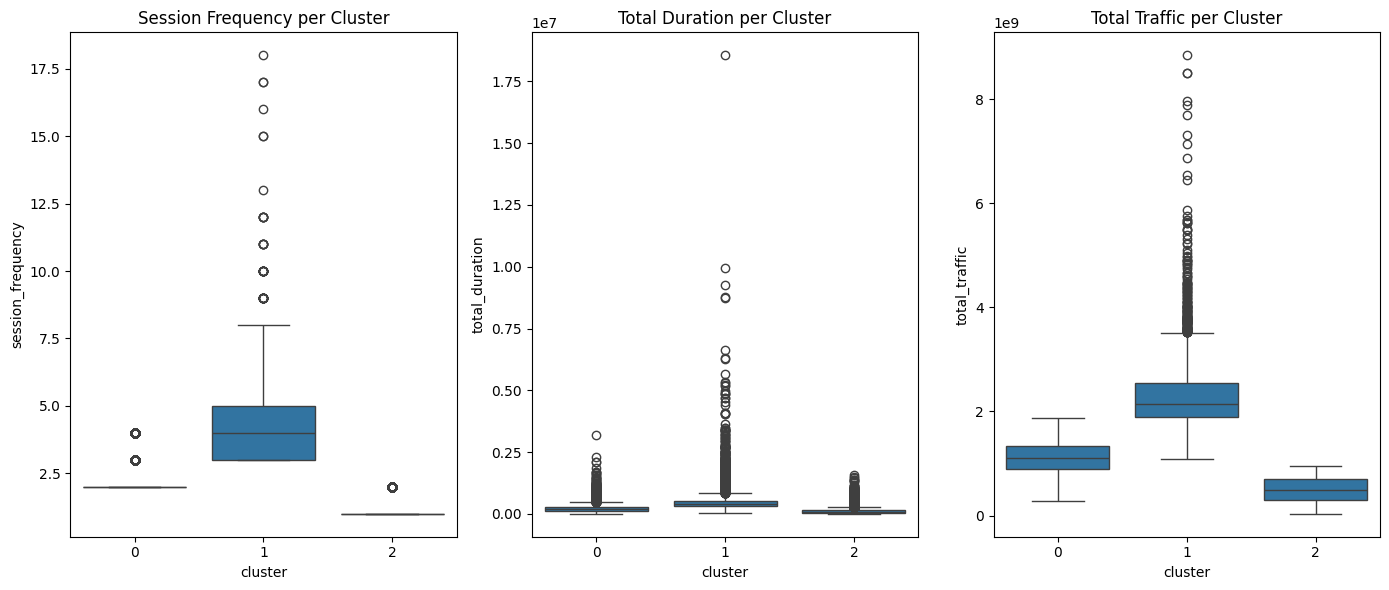

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the clusters for the three metrics: session frequency, total duration, and total traffic
plt.figure(figsize=(14, 6))

# Session Frequency Distribution
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster', y='session_frequency', data=engagement_metrics)
plt.title('Session Frequency per Cluster')

# Total Duration Distribution
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster', y='total_duration', data=engagement_metrics)
plt.title('Total Duration per Cluster')

# Total Traffic Distribution
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster', y='total_traffic', data=engagement_metrics)
plt.title('Total Traffic per Cluster')

plt.tight_layout()
plt.show()


In [176]:
print(engagement_metrics.columns)

Index(['MSISDN/Number', 'session_frequency', 'total_duration', 'total_traffic',
       'cluster'],
      dtype='object')


# Aggregate User Traffic Per Application

In [168]:
applications = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)',
       'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)',
       'Other DL (Bytes)']

In [ ]:
# Aggregate metrics per customer (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg(
    session_frequency=('Bearer Id', 'count'),  # Count sessions per user
    total_duration=('total_session_duration', 'sum'),  # Sum total duration per user
    total_traffic=('total_data', 'sum')  # Sum total data usage per user
).reset_index()

# Inspecting the top 10 customers for each engagement metric
top_session_frequency = engagement_metrics.nlargest(10, 'session_frequency')
top_total_duration = engagement_metrics.nlargest(10, 'total_duration')
top_total_traffic = engagement_metrics.nlargest(10, 'total_traffic')

# Display top customers for each metric
print("Top 10 Customers by Session Frequency")
print(top_session_frequency)

print("Top 10 Customers by Total Duration")
print(top_total_duration)

print("Top 10 Customers by Total Traffic")
print(top_total_traffic)


In [ ]:
# Assuming 'application' is a column representing the app usage
app_metrics = engagement_metrics.groupby('total_data').agg(
    total_app_traffic=('total_data', 'sum') 
).reset_index()

print(f"app metrics columns: {app_metrics.columns}")

# Get top 10 users per application
top_app_users = app_metrics.groupby('total_app_traffic').apply(lambda x: x.nlargest(10, 'total_app_traffic')).reset_index(drop=True)
print(top_app_users)


app metrics columns: Index(['total_data', 'total_app_traffic'], dtype='object')
          total_data  total_app_traffic
0       3.324901e+07       3.324901e+07
1       3.357584e+07       3.357584e+07
2       3.399962e+07       3.399962e+07
3       3.792924e+07       3.792924e+07
4       3.802236e+07       3.802236e+07
...              ...                ...
107255  7.891111e+09       7.891111e+09
107256  7.971167e+09       7.971167e+09
107257  8.499621e+09       8.499621e+09
107258  8.514774e+09       8.514774e+09
107259  8.846226e+09       8.846226e+09

[107260 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_11888\3796531043.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_app_users = app_metrics.groupby('total_app_traffic').apply(lambda x: x.nlargest(10, 'total_app_traffic')).reset_index(drop=True)


# Plot the Top 3 Most Used Applications

In [153]:
# Find top 3 most used applications
top_3_apps = app_metrics.groupby('application')['total_app_traffic'].sum().nlargest(3).index

# Filter the data for top 3 applications
top_3_app_metrics = app_metrics[app_metrics['application'].isin(top_3_apps)]

# Plot total traffic per application
plt.figure(figsize=(10, 6))
sns.barplot(x='application', y='total_app_traffic', data=top_3_app_metrics, palette='viridis')
plt.title('Top 3 Most Used Applications by Total Traffic')
plt.xlabel('Application', fontsize=12)
plt.ylabel('Total Traffic (Bytes)', fontsize=12)
plt.show()


NameError: name 'app_metrics' is not defined

# Optimizing the Value of k (Elbow Method)

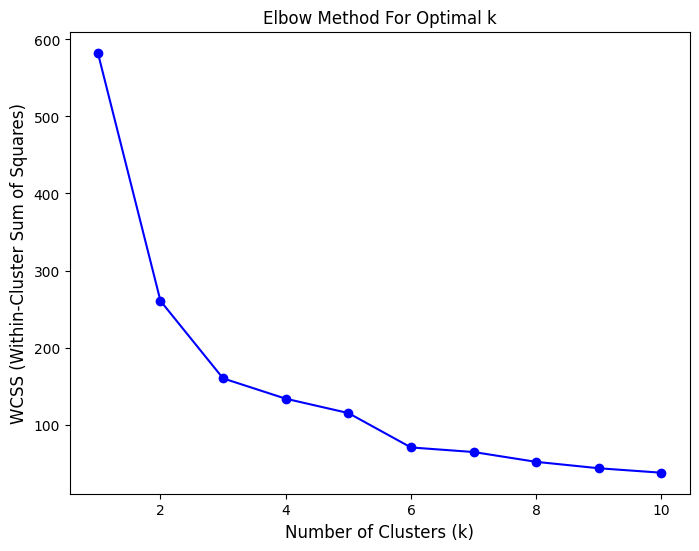

In [154]:
# Elbow method to determine the optimal k
wcss = []
for i in range(1, 11):  # Checking for k=1 to k=10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized_metrics_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', color='blue')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.show()


# Aggregating Metrics Per Customer

In [155]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Assuming 'df' is your DataFrame containing the data

# Handle missing values: numeric columns with mean, categorical columns with mode
numeric_columns = ['tcp_retransmission', 'rtt', 'throughput']  # Add other numeric columns if needed
categorical_columns = ['handset_type']  # Add any other categorical columns if needed

# Imputer for numeric columns (replace missing with mean)
numeric_imputer = SimpleImputer(strategy='mean')

# Imputer for categorical columns (replace missing with mode)
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Aggregate data per customer (MSISDN)
aggregated_data = df.groupby('MSISDN').agg(
    avg_tcp_retransmission=('tcp_retransmission', 'mean'),
    avg_rtt=('rtt', 'mean'),
    handset_type=('handset_type', 'first'),  # Assuming 'first' is the most frequent (as it's categorical)
    avg_throughput=('throughput', 'mean')
).reset_index()

# Display the aggregated data
print(aggregated_data.head())


KeyError: "None of [Index(['tcp_retransmission', 'rtt', 'throughput'], dtype='object')] are in the [columns]"

# Top, Bottom, and Most Frequent TCP, RTT, and Throughput Values

In [ ]:
# Top 10 values
top_tcp_retransmission = df['tcp_retransmission'].nlargest(10)
top_rtt = df['rtt'].nlargest(10)
top_throughput = df['throughput'].nlargest(10)

# Bottom 10 values
bottom_tcp_retransmission = df['tcp_retransmission'].nsmallest(10)
bottom_rtt = df['rtt'].nsmallest(10)
bottom_throughput = df['throughput'].nsmallest(10)

# Most frequent values (mode)
most_frequent_tcp = df['tcp_retransmission'].mode().iloc[0]
most_frequent_rtt = df['rtt'].mode().iloc[0]
most_frequent_throughput = df['throughput'].mode().iloc[0]

# Print the results
print("Top 10 TCP Retransmission values:", top_tcp_retransmission)
print("Top 10 RTT values:", top_rtt)
print("Top 10 Throughput values:", top_throughput)

print("Bottom 10 TCP Retransmission values:", bottom_tcp_retransmission)
print("Bottom 10 RTT values:", bottom_rtt)
print("Bottom 10 Throughput values:", bottom_throughput)

print("Most frequent TCP Retransmission value:", most_frequent_tcp)
print("Most frequent RTT value:", most_frequent_rtt)
print("Most frequent Throughput value:", most_frequent_throughput)


NameError: name 'aggregated_data' is not defined

# K-Means Clustering of User Experience

In [158]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting the features for clustering (excluding 'MSISDN' and 'handset_type')
cluster_data = aggregated_data[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']]

# Standardize the data before clustering
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Perform K-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_data['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Summary of the clusters
cluster_summary = aggregated_data.groupby('cluster').agg(
    avg_tcp_retransmission=('avg_tcp_retransmission', 'mean'),
    avg_rtt=('avg_rtt', 'mean'),
    avg_throughput=('avg_throughput', 'mean')
).reset_index()

# Print the cluster summary
print(cluster_summary)

# Visualize the clusters (optional, 2D projection)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_tcp_retransmission', y='avg_throughput', hue='cluster', data=aggregated_data, palette='Set1')
plt.title('User Experience Segmentation by K-Means (TCP Retransmission vs Throughput)')
plt.xlabel('Average TCP Retransmission')
plt.ylabel('Average Throughput')
plt.show()


NameError: name 'aggregated_data' is not defined

# Task 4.1 - Assign Engagement and Experience Scores

In [159]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Assuming `aggregated_data` contains the user's features and `cluster_summary` contains cluster centroids

# Cluster centroids from K-means clustering (we will use 'avg_tcp_retransmission', 'avg_rtt', 'avg_throughput')
# First cluster (least engaged) for engagement score
engagement_cluster_centroid = cluster_summary.iloc[0][['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']].values.reshape(1, -1)

# Worst experience cluster for experience score
experience_cluster_centroid = cluster_summary.iloc[2][['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']].values.reshape(1, -1)

# Compute Engagement Scores (Euclidean Distance to least engaged cluster)
engagement_scores = euclidean_distances(aggregated_data[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']], engagement_cluster_centroid)

# Compute Experience Scores (Euclidean Distance to worst experience cluster)
experience_scores = euclidean_distances(aggregated_data[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']], experience_cluster_centroid)

# Add scores to the dataframe
aggregated_data['engagement_score'] = engagement_scores
aggregated_data['experience_score'] = experience_scores

# Display the data with scores
print(aggregated_data[['MSISDN', 'engagement_score', 'experience_score']].head())


NameError: name 'cluster_summary' is not defined

# Compute the Satisfaction Score

In [160]:
# Calculate satisfaction score as the average of engagement and experience scores
aggregated_data['satisfaction_score'] = (aggregated_data['engagement_score'] + aggregated_data['experience_score']) / 2

# Report top 10 satisfied customers based on satisfaction score
top_10_satisfied = aggregated_data.nlargest(10, 'satisfaction_score')
print(top_10_satisfied[['MSISDN', 'satisfaction_score']])


NameError: name 'aggregated_data' is not defined

# Build a Regression Model to Predict Satisfaction Score

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select features for prediction (you can choose other features as needed)
X = aggregated_data[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']]  # Features
y = aggregated_data['satisfaction_score']  # Target: Satisfaction Score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict satisfaction scores
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) as a performance metric
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) of the regression model: {mse}")


NameError: name 'aggregated_data' is not defined

# Run K-Means on Engagement and Experience Scores (k=2)

In [162]:
# Combine engagement and experience scores into a new DataFrame
eng_experience_data = aggregated_data[['engagement_score', 'experience_score']]

# Perform K-means clustering (k=2)
kmeans_eng_experience = KMeans(n_clusters=2, random_state=42)
aggregated_data['eng_experience_cluster'] = kmeans_eng_experience.fit_predict(eng_experience_data)

# Summary of the new clusters
eng_experience_cluster_summary = aggregated_data.groupby('eng_experience_cluster').agg(
    avg_engagement_score=('engagement_score', 'mean'),
    avg_experience_score=('experience_score', 'mean'),
    avg_satisfaction_score=('satisfaction_score', 'mean')
).reset_index()

print(eng_experience_cluster_summary)


NameError: name 'aggregated_data' is not defined

# Aggregate the Average Satisfaction & Experience Score per Cluster

In [163]:
# Aggregate average satisfaction & experience scores per cluster
cluster_summary = aggregated_data.groupby('eng_experience_cluster').agg(
    avg_satisfaction_score=('satisfaction_score', 'mean'),
    avg_engagement_score=('engagement_score', 'mean'),
    avg_experience_score=('experience_score', 'mean')
).reset_index()

# Display the result
print(cluster_summary)


NameError: name 'aggregated_data' is not defined

# Export the Final Table to MySQL

In [ ]:
import pandas as pd
import psycopg2
import os

try:
    # Database connection
    conn = psycopg2.connect(
        dbname="telecom_data", 
        user="postgres", 
        password="125191", 
        host="localhost", 
        port="5432",
        options="-c client_encoding=UTF8"
    )

    # Create a cursor object
    cursor = conn.cursor()
    #  Create a table to store the results if it doesn't exist
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS user_scores (
        MSISDN VARCHAR(255),
        engagement_score FLOAT,
        experience_score FLOAT,
        satisfaction_score FLOAT
    )
    """)

    # Insert data into the table
    for index, row in aggregated_data.iterrows():
        cursor.execute("""
        INSERT INTO user_scores (MSISDN, engagement_score, experience_score, satisfaction_score)
        VALUES (%s, %s, %s, %s)
        """, (row['MSISDN'], row['engagement_score'], row['experience_score'], row['satisfaction_score']))

    # Commit the transaction
    conn.commit()

    # Run a select query to confirm the data has been inserted
    cursor.execute("SELECT * FROM user_scores LIMIT 10")
    result = cursor.fetchall()
    for row in result:
        print(row)

    # Close the cursor and connection
    cursor.close()
    conn.close()
   
except UnicodeDecodeError as e:
    print("Unicode decode error occurred:", e)
except Exception as e:
    print("Error occurred:", e)


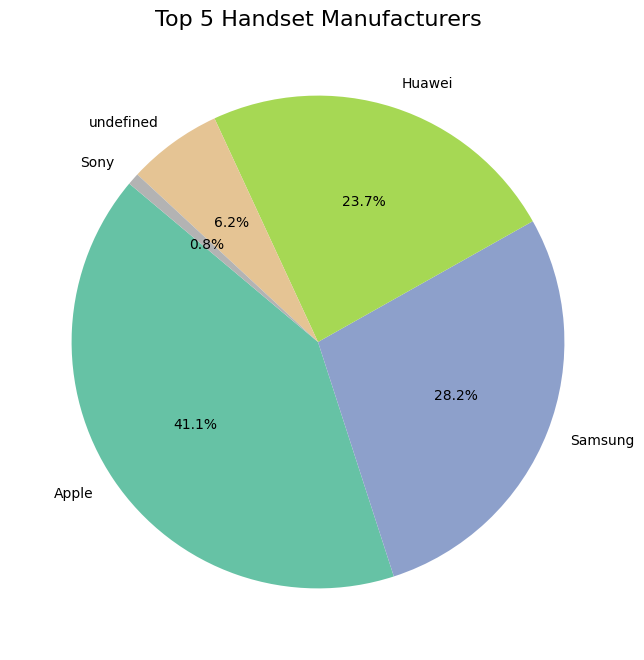

In [68]:
# Get top 5 manufacturers
top_manufacturers = df['Handset Manufacturer'].value_counts().head(5)

# Plot
plt.figure(figsize=(8, 8))
top_manufacturers.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='Set2')
plt.title('Top 5 Handset Manufacturers', fontsize=16)
plt.ylabel('')
plt.show()

In [14]:
import psycopg2
import pandas as pd

try:
    # Database connection
    conn = psycopg2.connect(
        dbname="TelCom", 
        user="postgres", 
        password="125191", 
        host="localhost", 
        port="5432"
    )
    
    # Set client encoding to match database
    cursor = conn.cursor()
    cursor.execute("SET client_encoding TO 'latin1'")
    
    # Fetch data using pandas
    query = "SELECT * FROM telecom"  # Replace with your table name
    df = pd.read_sql_query(query, conn)
    
    # Close the connection
    conn.close()
    
    # Display data
    print(df.info())
    print(df.describe())
    
except psycopg2.DatabaseError as e:
    print("Database error occurred:", e)
except Exception as e:
    print("An error occurred:", e)


An error occurred: 'utf-8' codec can't decode byte 0xe9 in position 84: invalid continuation byte


In [15]:
df.fillna(df.mean(), inplace=True)


NameError: name 'df' is not defined

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Filter outliers
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [ ]:
# Descriptive statistics
print(df.describe())

# Variable summary
print(df.info())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for session duration
plt.hist(df['session_duration'], bins=30, alpha=0.7)
plt.title("Distribution of Session Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df[['sessions_frequency', 'session_duration', 'total_traffic']])
df_scaled = pd.DataFrame(scaled_metrics, columns=['sessions_frequency', 'session_duration', 'total_traffic'])


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()



In [ ]:
optimal_k = 3  # Replace with the chosen k from the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)


In [ ]:
cluster_summary = df.groupby('cluster').agg({
    'sessions_frequency': ['min', 'max', 'mean', 'sum'],
    'session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})
print(cluster_summary)


#### Top 10 Handsets

In [ ]:
top_10_handsets = df['handset'].value_counts().head(10)
print(top_10_handsets)


#### Top 3 Manufacturers

In [ ]:
top_manufacturers = df['manufacturer'].value_counts().head(3)
print(top_manufacturers)

#### Top 5 Handsets per Manufacturer:

In [ ]:
for manufacturer in top_manufacturers.index:
    print(f"Top 5 handsets for {manufacturer}:")
    print(df[df['manufacturer'] == manufacturer]['handset'].value_counts().head(5))


##### Aggregate metrics per user

In [ ]:
app_columns = ['social_media_sessions', 'google_sessions', 'email_sessions', 
               'youtube_sessions', 'netflix_sessions', 'gaming_sessions', 'other_sessions']

df_user_agg = df.groupby('user_id').agg({
    'xDR_sessions': 'count',
    'session_duration': 'sum',
    'DL_data': 'sum',
    'UL_data': 'sum'
})

df_user_agg['total_data'] = df_user_agg['DL_data'] + df_user_agg['UL_data']
print(df_user_agg.head())


##### Missing values and Outliers

In [ ]:
df.fillna(df.mean(), inplace=True)


#Handled via IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


#### Reporting Metrics

##### Variables and Types

###### Variable Transformations

In [ ]:
df['duration_decile'] = pd.qcut(df['session_duration'], 10, labels=False)
decile_agg = df.groupby('duration_decile').agg({'total_data': 'sum'})
print(decile_agg)


###### Non-Graphical Univariate Analysis

In [ ]:
df[['xDR_sessions', 'session_duration', 'DL_data', 'UL_data']].describe()


###### Graphical Univariate Analysis

###### Bivariate Analysis

In [ ]:
sns.scatterplot(x='google_data', y='total_data', data=df)

#### Correlation Analysis

In [ ]:
app_columns = ['social_media_data', 'google_data', 'email_data', 'youtube_data', 'netflix_data', 'gaming_data', 'other_data']
corr_matrix = df[app_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


#### Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[app_columns])
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
